<a href="https://colab.research.google.com/github/MichalSlowakiewicz/Machine-Learning/blob/master/Homework9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Homework Assignment - *Do Androids Dream of Electric Sheep?***

-------------------------------------  

"Do Androids Dream of Electric Sheep?" – the famous title of Philip K. Dick’s novel – raises a fascinating question: if artificial intelligence could dream, what would it see?  

In this assignment, we explore a phenomenon known as **neural network dreams**, where instead of optimizing a neural network's weights, we **optimize the input itself** to achieve a desired classification outcome. Given a fully trained MNIST classification network, your goal is to manipulate its inputs so that it confidently predicts each digit from 0 to 9, starting from pure noise.  

## **Tasks Description**  

During this class we designed and trained a **MNIST classification neural network**, which takes a **batch of grayscale images** of size **$28 \times 28$** as input and outputs a probability distribution over the 10 digit classes (0–9). However, instead of using real MNIST images, you will **treat the input batch itself as a set of trainable parameters** and optimize it so that the network classifies each image as a specific digit.  

1. Your first task is to generate **a batch of 10 images**, where each image is
   classified as one of the digits **0, 1, 2, ..., 9**, starting from an initial batch of ten random Gaussian noise images.  

   Discuss the following question: do the generated images resemble real MNIST digits? Why or why not?  

2. Discuss, how you would approach a second task of
   generating an image that   
   bares similarity to two or more digits simultaneously. **Implement your idea to see the results.**

3. Third task: repeat the previous tasks with an additional L2 penalty on noise within the images. Experiment with adding `lambda_l2 * dreamed_input_batch.pow(2).mean()` loss term, with `lambda_l2` being the penalty cooefficient within an exponential progression, say from 0.001 to 10.0. Are the new digits recognized correctly? How does the penalty impact the digit quality? Explain.

### **Optimization Process for Task 1**  

1. Start with a **batch of 10 random Gaussian noise images** as the initial input and $(0, 1, 2, \ldots, 9)$ as the expected output batch of target digits.  
2. Define the objective: maximize the neural network's confidence for the corresponding target digit for each image in the batch.  
3. Use **gradient descent** to modify the pixels in each image, making the network classify each one as the assigned digit.  
4. Repeat until the network assigns suffieciently high confidence to each image’s target class.  

### **Implementation Details**  

- The neural network weights **must remain frozen** during optimization. You are modifying only the input images.  
- The loss function should be the **cross-entropy loss** between the predicted probabilities and the desired class labels (plus an optional weighted L2 penalty regularizing the images in task 3).


## **Points to Note**  

1. **Visualize** the optimization process: Save images of the generated inputs at different steps and plot the classification confidence evolution over iterations.  
3. **Document your findings** and explain the behavior you observe.  

## **Task & Deliverables**  

- A **Colab notebook** containing solutions for both tasks:
  - The full implementation.
  - Visualizations of the generated batch of images.
  - A written explanation of your observations.
- **Bonus:** If you create an **animation** showing the evolution of the input images during optimization, it will be considered a strong enhancement to your submission.
  - You can generate an animation programmatically (e.g., using Matplotlib or OpenCV).
  - Or, save image frames and use external tools to create a video.
  - Provide a **link** to any video files in the README.
- Upload your notebook and results to your **GitHub repository** for the course.
- In the **README**, include a **link** to the notebook.
- In the notebook, include **“Open in Colab”** badge so it can be launched directly.




In [1]:
import torch
import torchvision
import matplotlib.pyplot as plt


# reading MNIST dataset
trainset = torchvision.datasets.MNIST(root='./data',
                                      train=True,
                                      download=True,
                                      transform=None)

# mean and std of dataset
mean_dataset = trainset.data.numpy().mean()/255.0
std_dataset = trainset.data.numpy().std()/255.0

transform = torchvision.transforms.Compose(
    [ torchvision.transforms.ToTensor(), #Converts a PIL Image or numpy.ndarray (H x W x C) in the range [0, 255] to a torch.FloatTensor of shape (C x H x W) in the range [0.0, 1.0]
      torchvision.transforms.Normalize((mean_dataset), (std_dataset))])

trainset = torchvision.datasets.MNIST(root='./data',
                                      train=True,
                                      download=True,
                                      transform=transform)

trainloader = torch.utils.data.DataLoader(trainset,
                                          batch_size=2048,
                                          shuffle=True)   #we do shuffle it to give more randomizations to training epochs

testset = torchvision.datasets.MNIST(root='./data',
                                     train=False,
                                     download=True,
                                     transform=transform)

testloader = torch.utils.data.DataLoader(testset,
                                         batch_size=1,
                                         shuffle=False)


class MLP(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.relu = torch.nn.ReLU()
        self.flatten = torch.nn.Flatten()

        # Define all layers explicitly
        self.linear1 = torch.nn.Linear(1*28*28, 1024)  # First linear layer
        self.linear2 = torch.nn.Linear(1024, 2048)     # Second linear layer
        self.linear3 = torch.nn.Linear(2048, 256)      # Third linear layer
        self.linear4 = torch.nn.Linear(256, 10)        # Final linear layer (no activation)

        self.dropout = torch.nn.Dropout(0.05)

    def forward(self, x):      # Input shape: (B, 1, 28, 28)
        x = self.flatten(x)    # Shape: (B, 784)

        # Pass through all layers with ReLU activation
        x = self.relu(self.linear1(x))  # Shape: (B, 1024)
        x = self.relu(self.linear2(x))  # Shape: (B, 2048)
        x = self.relu(self.linear3(x))  # Shape: (B, 256)
        x = self.linear4(x)             # Shape: (B, 10) - no activation

        x = self.dropout(x)
        return x

100%|██████████| 9.91M/9.91M [00:01<00:00, 5.05MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 135kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.26MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 7.24MB/s]


In [67]:
# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Working on {device}")

net = MLP().to(device)
optimizer = torch.optim.Adam(net.parameters(), 0.001)   #initial and fixed learning rate of 0.001.

net.train()    #it notifies the network layers (especially batchnorm or dropout layers, which we don't use in this example) that we are doing traning
for epoch in range(8):  #  an epoch is a training run through the whole data set

    for batch, data in enumerate(trainloader):
        batch_inputs, batch_labels = data

        batch_inputs = batch_inputs.to(device)  #explicitly moving the data to the target device
        batch_labels = batch_labels.to(device)

        #batch_inputs.squeeze(1)     #alternatively if not for a Flatten layer, squeeze() could be used to remove the second order of the tensor, the Channel, which is one-dimensional (this index can be equal to 0 only)

        optimizer.zero_grad()

        batch_outputs = net(batch_inputs)   #this line calls the forward(self, x) method of the MLP object. Please note, that the last layer of the MLP is linear
                                            #and MLP doesn't apply
                                            #the nonlinear activation after the last layer
        loss = torch.nn.functional.cross_entropy(batch_outputs, batch_labels, reduction = "mean") #instead, nonlinear softmax is applied internally in THIS loss function
        print("epoch:", epoch, "batch:", batch, "current batch loss:", loss.item())
        loss.backward()       #this computes gradients as we have seen in previous workshops
        optimizer.step()     #but this line in fact updates our neural network.
                                ####You can experiment - comment this line and check, that the loss DOE

Working on cuda
epoch: 0 batch: 0 current batch loss: 2.3057167530059814
epoch: 0 batch: 1 current batch loss: 2.075727701187134
epoch: 0 batch: 2 current batch loss: 1.6071577072143555
epoch: 0 batch: 3 current batch loss: 1.10628080368042
epoch: 0 batch: 4 current batch loss: 1.143338918685913
epoch: 0 batch: 5 current batch loss: 1.6316657066345215
epoch: 0 batch: 6 current batch loss: 1.3576781749725342
epoch: 0 batch: 7 current batch loss: 0.9388776421546936
epoch: 0 batch: 8 current batch loss: 0.8874321579933167
epoch: 0 batch: 9 current batch loss: 0.7804363369941711
epoch: 0 batch: 10 current batch loss: 0.6757014989852905
epoch: 0 batch: 11 current batch loss: 0.6994125247001648
epoch: 0 batch: 12 current batch loss: 0.6922957301139832
epoch: 0 batch: 13 current batch loss: 0.6540037989616394
epoch: 0 batch: 14 current batch loss: 0.6192011833190918
epoch: 0 batch: 15 current batch loss: 0.5865840315818787
epoch: 0 batch: 16 current batch loss: 0.541375458240509
epoch: 0 batc

In [3]:
good = 0
wrong = 0

net.eval()              #it notifies the network layers (especially batchnorm or dropout layers, which we don't use in this example) that we are doing evaluation
with torch.no_grad():   #it prevents that the net learns during evalution. The gradients are not computed, so this makes it faster, too
    for batch, data in enumerate(testloader): #batches in test are of size 1
        datapoint, label = data

        prediction = net(datapoint.to(device))                  #prediction has values representing the "prevalence" of the corresponding class
        classification = torch.argmax(prediction)    #the class is the index of maximal "prevalence"

        if classification.item() == label.item():
            good += 1
        else:
            wrong += 1

print("accuracy = ", good/(good+wrong))

accuracy =  0.9832


Step 0, Loss: 21.6636, Confidence: [0.0, 0.001, 0.0, 0.0, 0.0, 0.0, 0.0, 0.017, 0.0, 0.0]
Step 50, Loss: 12.1187, Confidence: [0.0, 0.905, 0.244, 0.97, 0.0, 0.086, 0.0, 0.99, 0.0, 0.0]
Step 100, Loss: 6.2206, Confidence: [0.0, 0.975, 0.958, 0.99, 0.0, 0.948, 0.005, 0.994, 0.043, 0.0]
Step 150, Loss: 2.6267, Confidence: [0.015, 0.985, 0.978, 0.993, 0.0, 0.976, 0.955, 0.996, 0.951, 0.85]
Step 200, Loss: 1.0313, Confidence: [0.87, 0.99, 0.985, 0.995, 0.0, 0.984, 0.98, 0.997, 0.974, 0.973]
Step 250, Loss: 0.0347, Confidence: [0.956, 0.992, 0.989, 0.996, 0.805, 0.989, 0.986, 0.997, 0.982, 0.982]
Step 300, Loss: 0.0122, Confidence: [0.973, 0.994, 0.992, 0.997, 0.97, 0.992, 0.99, 0.998, 0.987, 0.987]
Step 350, Loss: 0.0090, Confidence: [0.981, 0.995, 0.993, 0.997, 0.98, 0.993, 0.992, 0.998, 0.99, 0.99]
Step 400, Loss: 0.0071, Confidence: [0.985, 0.996, 0.995, 0.998, 0.985, 0.995, 0.994, 0.999, 0.992, 0.992]
Step 450, Loss: 0.0058, Confidence: [0.988, 0.997, 0.996, 0.998, 0.989, 0.995, 0.995, 

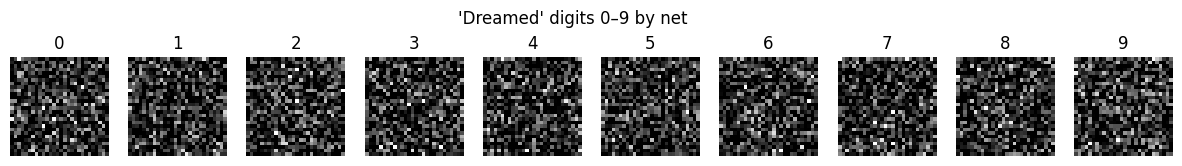

In [51]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

# freezeing weights
net.eval()
for param in net.parameters():
    param.requires_grad = False

# gaussian noise as input
dreamed_inputs = torch.randn((10, 1, 28, 28), device=device, requires_grad=True)

# i-th image -> i-th number
target_classes = torch.arange(10, device=device)

# optimizer for input
optimizer = torch.optim.Adam([dreamed_inputs], lr=0.001)

# for further normalizing
mean_tensor = torch.tensor(mean_dataset, device=device)
std_tensor = torch.tensor(std_dataset, device=device)

# optimalization
for step in range(1000):
    optimizer.zero_grad()

    # normalizing input
    normalized_inputs = (dreamed_inputs - mean_tensor) / std_tensor

    logits = net(normalized_inputs)
    loss = F.cross_entropy(logits, target_classes)

    loss.backward()
    optimizer.step()

    if step % 50 == 0 or step == 999:
        with torch.no_grad():
            probs = F.softmax(logits, dim=1)
            max_probs = probs.gather(1, target_classes.view(-1,1))
            print(f"Step {step}, Loss: {loss.item():.4f}, Confidence: {[round(p.item(), 3) for p in max_probs]}")

# inversing normalization for vizualization
dreamed_images_vis = dreamed_inputs.detach().cpu().clone()
dreamed_images_vis = dreamed_images_vis * std_dataset + mean_dataset
dreamed_images_vis = dreamed_images_vis.clamp(0, 1)

# vizualization
fig, axs = plt.subplots(1, 10, figsize=(15, 2))
for i in range(10):
    axs[i].imshow(dreamed_images_vis[i][0], cmap='gray')
    axs[i].axis('off')
    axs[i].set_title(str(i))
plt.suptitle("'Dreamed' digits 0–9 by net")
plt.show()


nie są podobne do prawdziwych liczb

In [47]:
mean_tensor

tensor(0.1307, device='cuda:0', dtype=torch.float64)

Step 0, Mean Target Prob: 0.0000
Step 50, Mean Target Prob: 0.4986
Step 100, Mean Target Prob: 0.4998
Step 150, Mean Target Prob: 0.4998
Step 200, Mean Target Prob: 0.4998
Step 250, Mean Target Prob: 0.4998
Step 299, Mean Target Prob: 0.4999
Step 300, Mean Target Prob: 0.4999
Step 350, Mean Target Prob: 0.4999
Step 400, Mean Target Prob: 0.4999
Step 450, Mean Target Prob: 0.4999
Step 500, Mean Target Prob: 0.4999
Step 550, Mean Target Prob: 0.4999
Step 600, Mean Target Prob: 0.4999
Step 650, Mean Target Prob: 0.4999
Step 700, Mean Target Prob: 0.4999
Step 750, Mean Target Prob: 0.4999
Step 800, Mean Target Prob: 0.5000
Step 850, Mean Target Prob: 0.5000
Step 900, Mean Target Prob: 0.5000
Step 950, Mean Target Prob: 0.5000


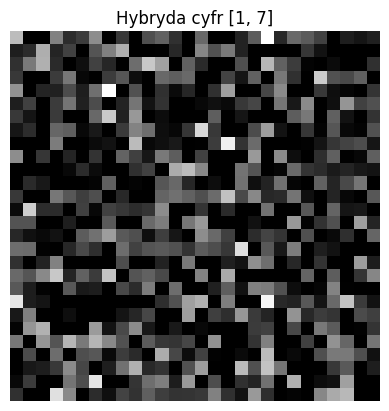

In [56]:
# choosing two digits
target_classes = [1, 7]

# initializing one image
hybrid_input = torch.randn((1, 1, 28, 28), device=device, requires_grad=True)

optimizer = torch.optim.Adam([hybrid_input], lr=0.001)

for step in range(1000):
    optimizer.zero_grad()

    normalized_input = (hybrid_input - mean_tensor) / std_tensor
    logits = net(normalized_input)
    probs = F.softmax(logits, dim=1)

    # Maksymalizujemy średnią prawdopodobieństw klas docelowych
    target_probs = probs[0, target_classes]
    loss = -target_probs.mean()

    loss.backward()
    optimizer.step()

    if step % 50 == 0 or step == 299:
        print(f"Step {step}, Mean Target Prob: {target_probs.mean().item():.4f}")

# Denormalizacja i wizualizacja
hybrid_image_vis = hybrid_input.detach().cpu().clone()
hybrid_image_vis = hybrid_image_vis * std_dataset + mean_dataset
hybrid_image_vis = hybrid_image_vis.clamp(0, 1)

plt.imshow(hybrid_image_vis[0, 0], cmap='gray')
plt.axis('off')
plt.title(f"Hybryda cyfr {target_classes}")
plt.show()


probs[0, target_classes]


=== Lambda L2: 0.0 ===
[0] CE: 14.7894, L2: 0.9671, Total: 14.7894
Confidences: [0.0, 0.0, 0.0, 0.0, 0.0, 0.985, 0.0, 0.102, 0.0, 0.0]
[200] CE: 0.0000, L2: 0.9765, Total: 0.0000
Confidences: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
[400] CE: 0.0000, L2: 0.9765, Total: 0.0000
Confidences: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
[600] CE: 0.0000, L2: 0.9765, Total: 0.0000
Confidences: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
[800] CE: 0.0000, L2: 0.9765, Total: 0.0000
Confidences: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
[999] CE: 0.0000, L2: 0.9765, Total: 0.0000
Confidences: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]

=== Lambda L2: 0.001 ===
[0] CE: 21.6562, L2: 0.9971, Total: 21.6572
Confidences: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.084, 0.0, 0.0]
[200] CE: 0.0000, L2: 1.0081, Total: 0.0010
Confidences: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
[400] CE: 0.0000, L2: 1.0077, Total: 0.0010
Confidences: [1.0, 1.0, 1.0, 1.0, 1.

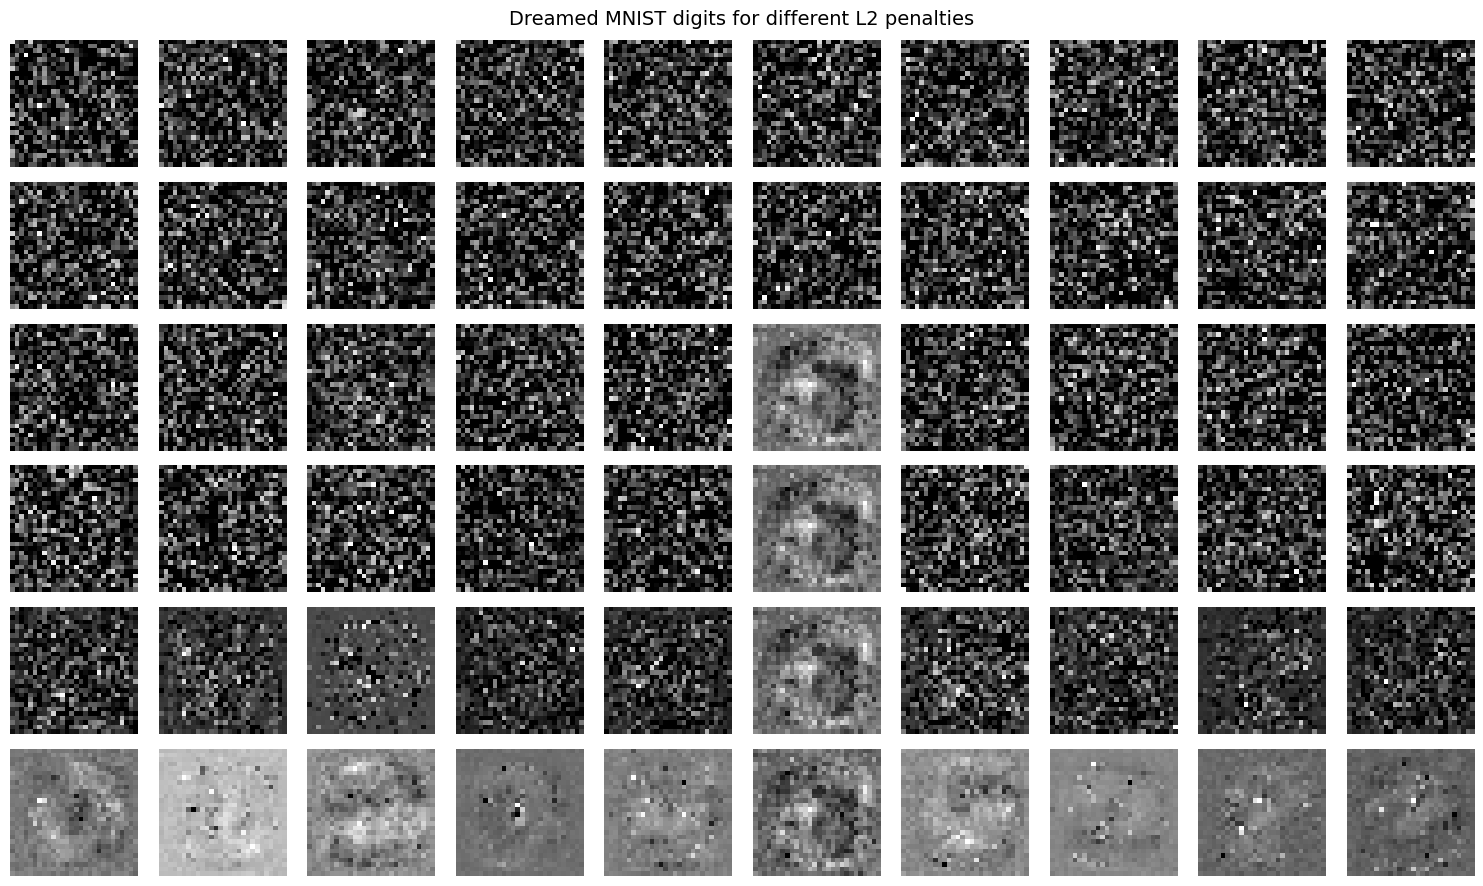

In [66]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

# Konfiguracja
net.eval()
for param in net.parameters():
    param.requires_grad = False

# Parametry
mean_dataset = 0.1307
std_dataset = 0.3081
device = next(net.parameters()).device

# Lista lambda L2 do przetestowania
lambda_l2_values = [0.0, 0.001, 0.01, 0.1, 1.0, 10.0]

# Przechowywanie wyników do wizualizacji
all_results = []

for lambda_l2 in lambda_l2_values:
    print(f"\n=== Lambda L2: {lambda_l2} ===")

    # Inicjalizacja wejść
    dreamed_inputs = torch.randn((10, 1, 28, 28), device=device, requires_grad=True)
    target_classes = torch.arange(10, device=device)
    optimizer = torch.optim.Adam([dreamed_inputs], lr=0.01)

    for step in range(1000):
        optimizer.zero_grad()
        normalized_inputs = (dreamed_inputs - mean_dataset) / std_dataset
        logits = net(normalized_inputs)

        # Strata: cross-entropy + kara L2
        ce_loss = F.cross_entropy(logits, target_classes)
        l2_loss = dreamed_inputs.pow(2).mean()
        total_loss = ce_loss + lambda_l2 * l2_loss

        total_loss.backward()
        optimizer.step()

        if step % 200 == 0 or step == 999:
            with torch.no_grad():
                probs = F.softmax(logits, dim=1)
                max_probs = probs.gather(1, target_classes.view(-1, 1))
                print(f"[{step}] CE: {ce_loss.item():.4f}, L2: {l2_loss.item():.4f}, Total: {total_loss.item():.4f}")
                print("Confidences:", [round(p.item(), 3) for p in max_probs])

    # Odskalowanie i odcięcie wartości
    with torch.no_grad():
        vis = dreamed_inputs.detach().cpu() * std_dataset + mean_dataset
        vis = vis.clamp(0, 1)
        all_results.append((lambda_l2, vis))

# Wizualizacja
fig, axs = plt.subplots(len(all_results), 10, figsize=(15, 1.5 * len(all_results)))
for row_idx, (lambda_l2, images) in enumerate(all_results):
    for col_idx in range(10):
        ax = axs[row_idx, col_idx] if len(all_results) > 1 else axs[col_idx]
        ax.imshow(images[col_idx][0], cmap='gray')
        ax.axis('off')
        if col_idx == 0:
            ax.set_ylabel(f"λ={lambda_l2}", rotation=0, labelpad=30)
plt.suptitle("Dreamed MNIST digits for different L2 penalties", fontsize=14)
plt.tight_layout()
plt.show()


Step 0, Loss: 19.6347, Confidence: [0.0, 0.0, 0.0, 0.0, 0.0, 0.003, 0.0, 0.0, 0.0, 0.0], L2 Penalty: 0.0010
Step 50, Loss: 9.6052, Confidence: [0.0, 0.0, 0.77, 0.0, 0.0, 0.989, 0.0, 0.0, 0.0, 0.008], L2 Penalty: 0.0016
Step 100, Loss: 1.9890, Confidence: [0.003, 0.304, 0.977, 0.002, 0.63, 0.993, 0.015, 0.53, 0.221, 0.965], L2 Penalty: 0.0025
Step 150, Loss: 0.0582, Confidence: [0.847, 0.92, 0.986, 0.928, 0.967, 0.995, 0.937, 0.975, 0.944, 0.982], L2 Penalty: 0.0040
Step 200, Loss: 0.0294, Confidence: [0.959, 0.96, 0.99, 0.975, 0.98, 0.996, 0.97, 0.984, 0.971, 0.987], L2 Penalty: 0.0063
Step 250, Loss: 0.0254, Confidence: [0.975, 0.974, 0.993, 0.984, 0.986, 0.997, 0.979, 0.988, 0.98, 0.991], L2 Penalty: 0.0100
Step 300, Loss: 0.0272, Confidence: [0.983, 0.981, 0.994, 0.988, 0.99, 0.997, 0.985, 0.991, 0.986, 0.993], L2 Penalty: 0.0159
Step 350, Loss: 0.0340, Confidence: [0.987, 0.986, 0.996, 0.991, 0.992, 0.998, 0.988, 0.993, 0.989, 0.994], L2 Penalty: 0.0252
Step 400, Loss: 0.0470, Conf

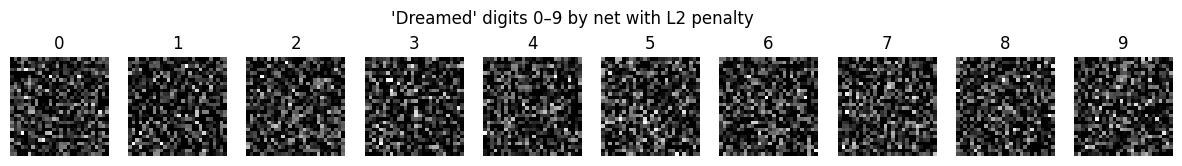

In [61]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

# freezeing weights
net.eval()
for param in net.parameters():
    param.requires_grad = False

# gaussian noise as input
dreamed_inputs = torch.randn((10, 1, 28, 28), device=device, requires_grad=True)

# i-th image -> i-th number
target_classes = torch.arange(10, device=device)

# optimizer for input
optimizer = torch.optim.Adam([dreamed_inputs], lr=0.001)

# for further normalizing
mean_tensor = torch.tensor(mean_dataset, device=device)
std_tensor = torch.tensor(std_dataset, device=device)

# optimalization with L2 penalty
lambda_l2_start = 0.001
lambda_l2_end = 10.0
steps = 1000
for step in range(steps):
    optimizer.zero_grad()

    # Calculate the L2 penalty term
    lambda_l2 = lambda_l2_start * (lambda_l2_end / lambda_l2_start) ** (step / steps)  # exponential progression
    l2_penalty = lambda_l2 * dreamed_inputs.pow(2).mean()  # L2 penalty on noise

    # normalizing input
    normalized_inputs = (dreamed_inputs - mean_tensor) / std_tensor

    logits = net(normalized_inputs)
    loss = F.cross_entropy(logits, target_classes) + l2_penalty  # add L2 penalty to the loss

    loss.backward()
    optimizer.step()

    if step % 50 == 0 or step == 999:
        with torch.no_grad():
            probs = F.softmax(logits, dim=1)
            max_probs = probs.gather(1, target_classes.view(-1,1))
            print(f"Step {step}, Loss: {loss.item():.4f}, Confidence: {[round(p.item(), 3) for p in max_probs]}, L2 Penalty: {l2_penalty.item():.4f}")

# inversing normalization for visualization
dreamed_images_vis = dreamed_inputs.detach().cpu().clone()
dreamed_images_vis = dreamed_images_vis * std_dataset + mean_dataset
dreamed_images_vis = dreamed_images_vis.clamp(0, 1)

# visualization
fig, axs = plt.subplots(1, 10, figsize=(15, 2))
for i in range(10):
    axs[i].imshow(dreamed_images_vis[i][0], cmap='gray')
    axs[i].axis('off')
    axs[i].set_title(str(i))
plt.suptitle(f"'Dreamed' digits 0–9 by net with L2 penalty")
plt.show()
